In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys; sys.path.append('..')
import pyzx as zx
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

import numpy as np
from math import pi

Available backends: simple, igraph


In [12]:
g = zx.cliffords(2, 4,no_hadamard=True)

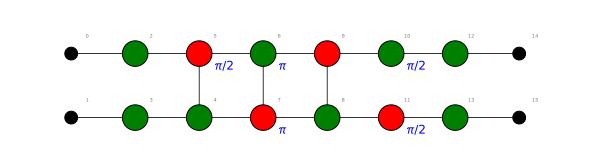

In [13]:
zx.draw(g,labels=True)

In [16]:
t = tensorfy(g)
print(t)

[[0, 1], [2, 3], [3, 4, 5], [1, 4, 6], [6, 7, 8], [5, 8, 9], [9, 10, 11], [7, 10, 12], [12, 13], [11, 14], [13, 15], [14, 16]]
[0, 2, 15, 16]
[[[[-0.        +0.j         -0.        +0.j        ]
   [-0.        +0.j         -0.35355339+0.j        ]]

  [[ 0.        +0.j         -0.        -0.35355339j]
   [ 0.        +0.j         -0.        -0.j        ]]]


 [[[-0.        +0.j          0.        -0.j        ]
   [ 0.35355339-0.j         -0.        +0.j        ]]

  [[ 0.        +0.35355339j  0.        +0.j        ]
   [ 0.        -0.j         -0.        -0.j        ]]]]


In [17]:
print(np.transpose(t,[1,3,0,2]))

[[[[-0.        +0.j         -0.        +0.j        ]
   [-0.        +0.j          0.35355339-0.j        ]]

  [[-0.        +0.j         -0.35355339+0.j        ]
   [ 0.        -0.j         -0.        +0.j        ]]]


 [[[ 0.        +0.j          0.        +0.j        ]
   [ 0.        +0.35355339j  0.        -0.j        ]]

  [[-0.        -0.35355339j -0.        -0.j        ]
   [ 0.        +0.j         -0.        -0.j        ]]]]


In [4]:
np.version.version

'1.14.5'

In [18]:
g2 = g.copy()
zx.clifford_simp(g2)
t2 = tensorfy(g2)

spider_simp
2. 
finished in 2 iterations
lcomp_simp
2. 2. 
finished in 3 iterations
pivot_simp

finished in 1 iterations
id_simp

finished in 1 iterations
[[0, 1, 2], [3, 4], [1, 5], [2, 4, 6, 7], [6, 8], [5, 7, 9]]
[0, 3, 8, 9]


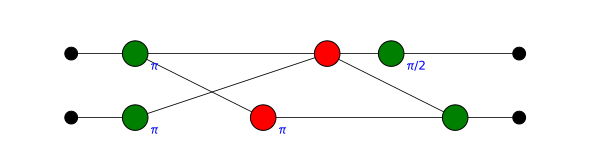

In [19]:
zx.draw(g2)

In [20]:
print(t2)

[[[[ 0. +0.j   0. +0.j ]
   [ 0. +0.j   0. +0.5j]]

  [[ 0. +0.j  -0.5+0.j ]
   [ 0. -0.j   0. +0.j ]]]


 [[[ 0. +0.j  -0. -0.j ]
   [-0. -0.5j  0. +0.j ]]

  [[ 0.5-0.j   0. +0.j ]
   [ 0. +0.j  -0. +0.j ]]]]


In [26]:
t2[1,0,1,0]

(-1.2246467991473537e-16-0.5000000000000002j)

In [58]:
g3 = zx.Graph()
g3.add_vertices(6)
g3.set_type(2,1)
g3.set_type(3,2)
g3.add_edges([(2,3),(0,2),(1,3),(2,4),(3,5)])
print(tensorfy(g3))

[[0, 1, 2], [0, 3, 4]]
{1, 2, 3, 4}
[[[[ 0.70710678+0.j  0.00000000+0.j]
   [ 0.00000000+0.j  0.70710678+0.j]]

  [[ 0.00000000+0.j  0.00000000+0.j]
   [ 0.00000000+0.j  0.00000000+0.j]]]


 [[[ 0.00000000+0.j  0.00000000+0.j]
   [ 0.00000000+0.j  0.00000000+0.j]]

  [[ 0.00000000+0.j  0.70710678+0.j]
   [ 0.70710678+0.j  0.00000000+0.j]]]]


In [8]:
def Z_to_tensor(arity, phase):
    m = np.zeros([2]*arity, dtype = complex)
    m[(0,)*arity] = 1
    m[(1,)*arity] = np.exp(1j*phase)
    return m

def X_to_tensor(arity, phase):
    m = np.ones(2**arity, dtype = complex)
    for i in range(2**arity):
        if bin(i).count("1")%2 == 0: 
            m[i] += np.exp(1j*phase)
        else:
            m[i] -= np.exp(1j*phase)
    return np.power(np.sqrt(0.5),arity)*m.reshape([2]*arity)

In [15]:
def tensorfy(g):
    '''Takes in a Graph and outputs a multidimensional numpy array
    representing the linear map the ZX-diagram implements'''
    tensors = []
    int_vertices = {}
    inputs = []

    types = g.get_types()
    phases = g.get_angles()

    for v in g.vertices():
        if types[v] in (1,2):
            phase = pi*phases[v]
            int_vertices[v] = len(tensors)
            d = g.get_vertex_degree(v)
            tensors.append(Z_to_tensor(d,phase) if types[v] == 1 else X_to_tensor(d,phase))
        elif types[v] == 0:
            if g.get_vdata(v,'i'):
                inputs.append(v)
        else:
            raise Exception("Wrong type for node with index {!s}: {!s}".format(v,types[v]))

    conns = []
    contraction_count = {v:0 for v in int_vertices}
    for v in inputs:
        for n in g.get_neighbours(v): contraction_count[n] += 1
    for e in g.edges():
        s,t = g.edge_st(e)
        if not (s in int_vertices and t in int_vertices): continue
        conns.append(((int_vertices[s],contraction_count[s]),
                     (int_vertices[t],contraction_count[t])))
        contraction_count[s] += 1
        contraction_count[t] += 1

    #print(conns)

    return contract_all(tensors, conns)

In [10]:
def contract_all(tensors,conns):
    '''
    Contract the tensors inside the list tensors
    according to the connectivities in conns

    Due to limitations in numpy, only up to 26 contractions can be done.

    Example input:
    tensors = [np.random.rand(2,3),np.random.rand(3,4,5),np.random.rand(3,4)]
    conns = [((0,1),(2,0)), ((1,1),(2,1))]
    returned shape in this case is (2,3,5)
    Taken from https://stackoverflow.com/questions/42034480/efficient-tensor-contraction-in-python
    '''

    ndims = [t.ndim for t in tensors]
    totdims = sum(ndims)
    dims0 = np.arange(totdims)
    # keep track of sublistout throughout
    sublistout = set(dims0.tolist())
    # cut up the index array according to tensors
    # (throw away empty list at the end)
    inds = np.split(dims0,np.cumsum(ndims))[:-1]
    # we also need to convert to a list, otherwise einsum chokes
    inds = [ind.tolist() for ind in inds]

    # if there were no contractions, we'd call
    # np.einsum(*zip(tensors,inds),sublistout)

    # instead we need to loop over the connectivity graph
    # and manipulate the indices
    for (m,i),(n,j) in conns:
        # tensors[m][i] contracted with tensors[n][j]

        # remove the old indices from sublistout which is a set
        sublistout -= {inds[m][i],inds[n][j]}

        # contract the indices
        inds[n][j] = inds[m][i]

    #There are now 'holes' in the used indices.
    #Since numpy only supports indices up to 26, we will
    #lower the indices down as much as possible before continuing.
    used_indices = set()
    for l in inds:
        used_indices.update(l)
    remap = {k:v for (v,k) in enumerate(list(used_indices))}
    for i in range(len(inds)):
      inds[i] = [remap[j] for j in inds[i]]
    s2 = set()
    for i in sublistout:
        s2.add(remap[i])
    sublistout = list(s2)
    sublistout.sort()
    
    print(inds)
    print(sublistout)

    # zip and flatten the tensors and indices
    args = [subarg for arg in zip(tensors,inds) for subarg in arg]
    args.append(sublistout)

    # assuming there are no multiple contractions, we're done here
    return np.einsum(*args)